# Εξαμηνιαία Εργασία για το μάθημα "Εργαστήριο Βιοίτρικής Τεχνολογίας"

## 0. Setup

In [1]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu118
torch version: 2.0.1+cu118
torchvision version: 0.15.2+cu118


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

plt.rcParams["font.family"] = "serif"


from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

[INFO] Couldn't find torchinfo... installing it.


Enable CUDA support

In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Prepare Data

In [4]:
!wget "https://ntuagr-my.sharepoint.com/:u:/g/personal/el17811_ntua_gr/EbHsgnsMBJ5IkEu_n4X-vCMBLuE5CY2paIuuwEEDtMB-2w?e=FNflGw&download=1" -O Dataset.zip
!unzip -o -qq Dataset.zip
!rm Dataset.zip

--2023-06-11 09:59:32--  https://ntuagr-my.sharepoint.com/:u:/g/personal/el17811_ntua_gr/EbHsgnsMBJ5IkEu_n4X-vCMBLuE5CY2paIuuwEEDtMB-2w?e=FNflGw&download=1
Resolving ntuagr-my.sharepoint.com (ntuagr-my.sharepoint.com)... 52.107.252.34, 52.107.252.18, 52.107.252.31, ...
Connecting to ntuagr-my.sharepoint.com (ntuagr-my.sharepoint.com)|52.107.252.34|:443... connected.
HTTP request sent, awaiting response... 302 
Location: /personal/el17811_ntua_gr/Documents/%ce%95%cf%81%ce%b3%ce%b1%cf%83%cf%84%ce%ae%cf%81%ce%b9%ce%bf%20%ce%92%ce%b9%ce%bf%ce%b9%ce%b1%cf%84%cf%81%ce%b9%ce%ba%ce%ae%cf%82%20%ce%a4%ce%b5%cf%87%ce%bd%ce%bf%ce%bb%ce%bf%ce%b3%ce%af%ce%b1%cf%82/Dataset.zip?ga=1 [following]
--2023-06-11 09:59:34--  https://ntuagr-my.sharepoint.com/personal/el17811_ntua_gr/Documents/%ce%95%cf%81%ce%b3%ce%b1%cf%83%cf%84%ce%ae%cf%81%ce%b9%ce%bf%20%ce%92%ce%b9%ce%bf%ce%b9%ce%b1%cf%84%cf%81%ce%b9%ce%ba%ce%ae%cf%82%20%ce%a4%ce%b5%cf%87%ce%bd%ce%bf%ce%bb%ce%bf%ce%b3%ce%af%ce%b1%cf%82/Dataset.zip?ga=1
Reu

## 2. Load Training Data


In [5]:
# Setup Dirs
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

# Not so random after all
torch.manual_seed(42)

manual_transforms = transforms.Compose([
    transforms.Resize((600, 600)),                    # 1. Reshape all images to 600x600 
    transforms.ToTensor(),                            # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225])   # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

data = datasets.ImageFolder("./Dataset", transform=manual_transforms)

train_data, test_data, validation_data =  torch.utils.data.random_split(data, [0.6, 0.25, 0.15])

class_names = data.classes

train_dataloader = DataLoader(
    train_data,
    batch_size=32,
    shuffle=True,
    num_workers=os.cpu_count(),
    pin_memory=True,
)

test_dataloader = DataLoader(
    test_data,
    batch_size=32,
    shuffle=False,
    num_workers=os.cpu_count(),
    pin_memory=True,
)

validation_dataloader = DataLoader(
    validation_data,
    batch_size=32,
    shuffle=True,
    num_workers=os.cpu_count(),
    pin_memory=True,
)



### Create a transform for `torchvision.models`



In [6]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B7_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_B7_Weights.IMAGENET1K_V1

In [7]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[600]
    resize_size=[600]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

## 3. Get pretrained model

We will use EfficientNet_B7

In [8]:

weights = torchvision.models.EfficientNet_B7_Weights.DEFAULT                    # .DEFAULT = best available weights 
model = torchvision.models.efficientnet_b7(weights=weights).to(device)

#model # uncomment to output

Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-dcc49843.pth
100%|██████████| 255M/255M [00:16<00:00, 16.5MB/s]


### Get model Summary


In [9]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(32, 3, 600, 600), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 600, 600]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 600, 600]    [32, 2560, 19, 19]   --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 600, 600]    [32, 64, 300, 300]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 600, 600]    [32, 64, 300, 300]   1,728                True
│    │    └─BatchNorm2d (1)                                  [32, 64, 300, 300]   [32, 64, 300, 300]   128                  True
│    │    └─SiLU (2)                                         [32, 64, 300, 300]   [32, 64, 300, 300]   --                   --
│    └─Sequential (1)                                        [32, 64, 300, 300]   [32, 32, 300

### Freeze Model

In [10]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

In [11]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=2560, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

### Get summary of frozen model

In [12]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model, 
        input_size=(32, 3, 600, 600), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 600, 600]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 600, 600]    [32, 2560, 19, 19]   --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 600, 600]    [32, 64, 300, 300]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 600, 600]    [32, 64, 300, 300]   (1,728)              False
│    │    └─BatchNorm2d (1)                                  [32, 64, 300, 300]   [32, 64, 300, 300]   (128)                False
│    │    └─SiLU (2)                                         [32, 64, 300, 300]   [32, 64, 300, 300]   --                   --
│    └─Sequential (1)                                        [32, 64, 300, 300]   [32, 

## 4. Model Trainning 


In [15]:
### From: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/engine.py

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

In [13]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=15,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8545 | train_acc: 0.7319 | test_loss: 0.9407 | test_acc: 0.5157
Epoch: 2 | train_loss: 0.5477 | train_acc: 0.8674 | test_loss: 0.8052 | test_acc: 0.6591
Epoch: 3 | train_loss: 0.4219 | train_acc: 0.8938 | test_loss: 0.6763 | test_acc: 0.7420
Epoch: 4 | train_loss: 0.3470 | train_acc: 0.9061 | test_loss: 0.5757 | test_acc: 0.7876
Epoch: 5 | train_loss: 0.3056 | train_acc: 0.9224 | test_loss: 0.4744 | test_acc: 0.8315
Epoch: 6 | train_loss: 0.2750 | train_acc: 0.9330 | test_loss: 0.3818 | test_acc: 0.8797
Epoch: 7 | train_loss: 0.2740 | train_acc: 0.9163 | test_loss: 0.3251 | test_acc: 0.8967
Epoch: 8 | train_loss: 0.2272 | train_acc: 0.9447 | test_loss: 0.2733 | test_acc: 0.9205
Epoch: 9 | train_loss: 0.2446 | train_acc: 0.9390 | test_loss: 0.2336 | test_acc: 0.9444
Epoch: 10 | train_loss: 0.2285 | train_acc: 0.9267 | test_loss: 0.2090 | test_acc: 0.9444
Epoch: 11 | train_loss: 0.2143 | train_acc: 0.9507 | test_loss: 0.1901 | test_acc: 0.9514
Epoch: 12 | train_l

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=c94fe76188961d58596016621ed0b39edd2a7ad6257925f663a48b4fc3c217c2
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


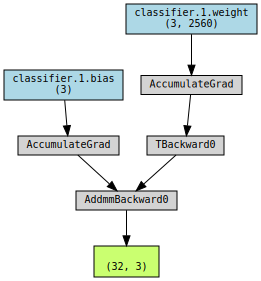

In [18]:
try:
  from torchviz import make_dot
except:
  !pip install torchviz graphviz
  from torchviz import make_dot

torch.cuda.empty_cache()

x = torch.randn(32, 3, 600, 600).to(device)
y = model(x)
make_dot(y, params=dict(model.named_parameters()))

## 5. Model Evaluation

In [19]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


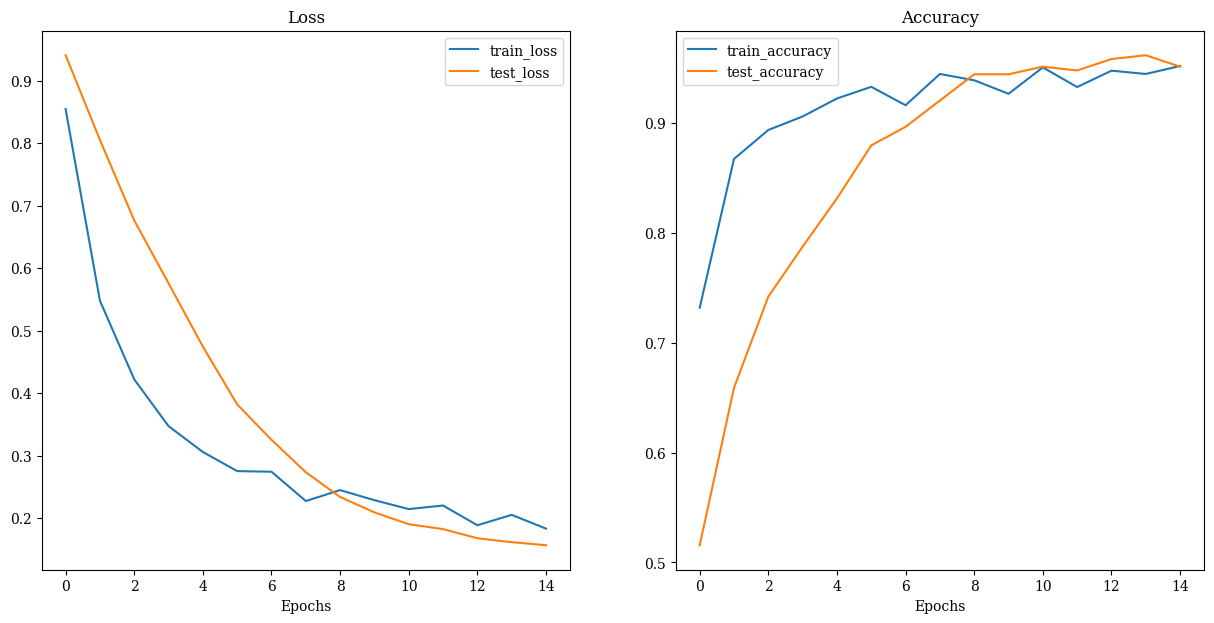

In [20]:
plot_loss_curves(results)

## 6. Predictions on images from the test set

In [21]:
from typing import List, Tuple

from PIL import Image

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_i: int,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (600, 600),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    
    img = Image.open(image_path)

    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    model.to(device)

    model.eval()
    with torch.inference_mode():
      transformed_image = image_transform(img).unsqueeze(dim=0)
      target_image_pred = model(transformed_image.to(device))

    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    plt.imshow(img)
    plt.title(f"{class_names[class_i]}\nPred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max() * 100.0 :3.1f}%")
    plt.axis(False);

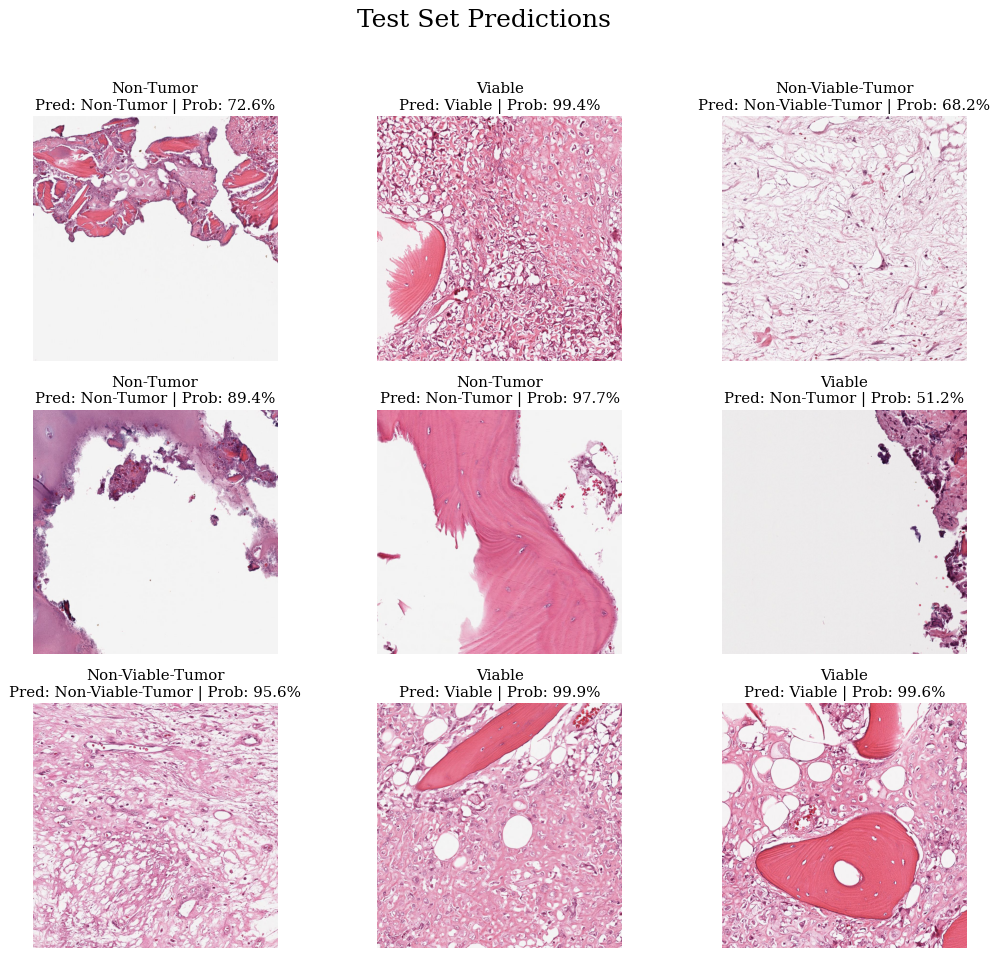

In [22]:
# Get a random list of image paths from test set
import random

from pathlib import Path


num_images_to_plot = 9
test_image_path_sample = random.sample(population=test_data.dataset.imgs, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# # Make predictions on and plot the images
i = 1
plt.figure(figsize=(14, 12), dpi=90)
plt.suptitle("Test Set Predictions", fontsize=20)

plt.tight_layout() 
for image_path, class_idx in test_image_path_sample:
    plt.subplot(3, 3, i)
    i+=1
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_i=class_idx,
                        class_names=class_names,
                        transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(600, 600))

## 7. Predictions on Validation Set

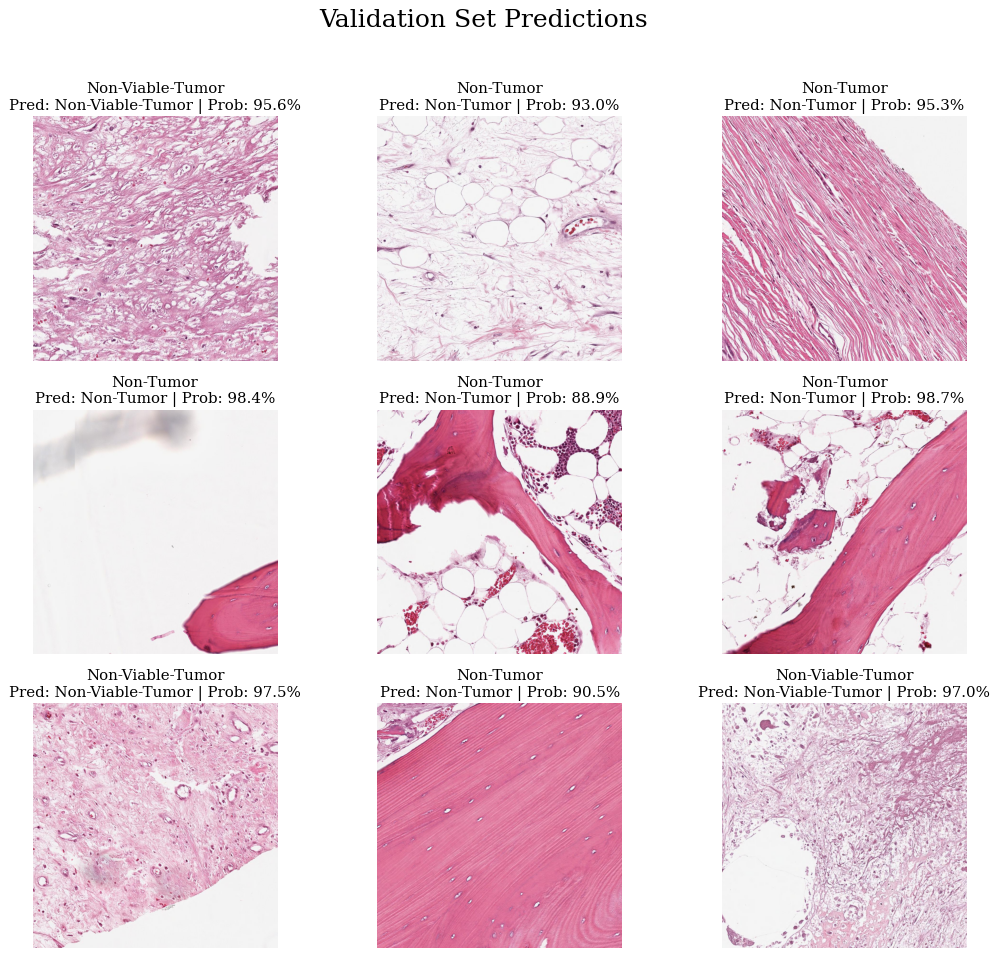

In [23]:
# Get a random list of image paths from test set

num_images_to_plot = 9
test_image_path_sample = random.sample(population=validation_data.dataset.imgs, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# # Make predictions on and plot the images
i = 1
plt.figure(figsize=(14, 12), dpi=90)
plt.suptitle("Validation Set Predictions", fontsize=20)
plt.tight_layout() 
for image_path, class_idx in test_image_path_sample:
    plt.subplot(3, 3, i)
    i+=1
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_i=class_idx,
                        class_names=class_names,
                        transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(600, 600))

## 8. Model Metrics

In [24]:
try:
  import torchmetrics
except :
    !pip install torchmetrics
    import torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 35.7 MB/s eta 0:00:00


In [25]:

val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=3, average="none").to(device)
val_spe = torchmetrics.Specificity(task="multiclass", num_classes=3, average="none").to(device)
val_pre = torchmetrics.Precision(task="multiclass", num_classes=3, average="none").to(device)
val_rec = torchmetrics.Recall(task="multiclass", num_classes=3, average="none").to(device)
val_f1s = torchmetrics.F1Score(task="multiclass", num_classes=3, average="none").to(device)

conf_matrix = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=3).to(device)

model.to(device)
model.eval()

for idx, (data, target) in enumerate (validation_dataloader):
    data, target = data.to(device), target.to(device)
    preds = model(data)
    # metric on current batch
    val_acc.forward(preds, target)
    val_spe.forward(preds, target)
    val_pre.forward(preds, target)
    val_rec.forward(preds, target)
    val_f1s.forward(preds, target)
    conf_matrix.forward(preds, target)
  
# metric on all batches using custom accumulation
val_acc = val_acc.compute().to('cpu').tolist()
val_spe = val_spe.compute().to('cpu').tolist()
val_pre = val_pre.compute().to('cpu').tolist()
val_rec = val_rec.compute().to('cpu').tolist()
val_f1s = val_f1s.compute().to('cpu').tolist()

conf_matrix = conf_matrix.compute()

print(f"Used {len(validation_dataloader.dataset)} images for validation")
print()
print(class_names)
print(f"Accuracy:\t{val_acc:}")
print(f"Specificity:\t{val_spe}")
print(f"Precision:\t{val_pre}")
print(f"Recall: \t{val_rec:}")
print(f"F1-Score:\t{val_f1s}")
print()
print(conf_matrix)

Used 163 images for validation

['Non-Tumor', 'Non-Viable-Tumor', 'Viable']
Accuracy:	[0.987500011920929, 0.8888888955116272, 0.957446813583374]
Specificity:	[0.9397590160369873, 0.9921259880065918, 0.9913793206214905]
Precision:	[0.9404761791229248, 0.9696969985961914, 0.97826087474823]
Recall: 	[0.987500011920929, 0.8888888955116272, 0.957446813583374]
F1-Score:	[0.9634146094322205, 0.9275362491607666, 0.9677419066429138]

tensor([[79,  1,  0],
        [ 3, 32,  1],
        [ 2,  0, 45]], device='cuda:0')


In [26]:
try:
  import pandas as pd
  import seaborn as sn
  
except:
  !pip install seaborn pandas
  import pandas as pd
  import seaborn as sn

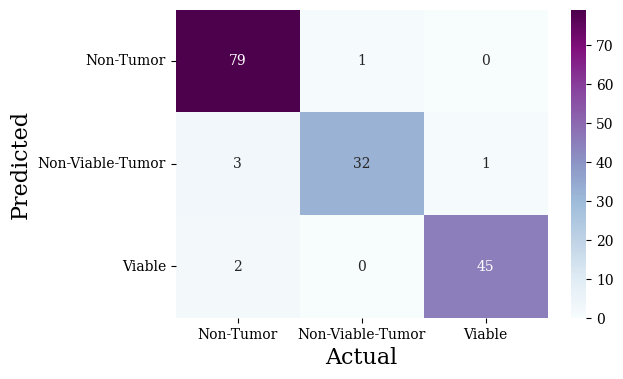

In [27]:
import pandas as pd
import seaborn as sn

conf_matrix = conf_matrix.to('cpu')

df_cm = pd.DataFrame(conf_matrix, index = [i for i in class_names],
                  columns = [i for i in class_names])

plt.figure(figsize = (6,4))
sn.heatmap(df_cm, annot=True, cmap='BuPu')
plt.xlabel("Actual", fontsize=16)
plt.ylabel("Predicted", fontsize=16)
plt.show()